<a href="https://colab.research.google.com/github/fsommers/documentai/blob/main/Document_Similarity_with_ColPali_0_2_2_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Document Similarity with ColPali

*ColPali 0.2.2 version. 0.3.0 version coming*

This notebook shows a quick demo of how you might use [ColPali](https://huggingface.co/vidore/colpali-v1.2) for document similarity-based retrieval: Given document $D$, and corpus $C$,

*Find all documents in corpus $C$ that are similar to document $D$*

ColPali implements ColBERT-style multi-vector and late interaction retrieval for a vision language model, Google's [PaliGemma](https://huggingface.co/blog/paligemma) in this case. The ColPali approach can be implemented for other VLMs, too; there's already ColIdefics in the works. The full [paper](https://arxiv.org/abs/2407.01449) has the gory details, and a [blog post](https://huggingface.co/blog/manu/colpali) provides a brief introduction.

ColPali's approach is a step change in document AI. Documents–as in business documents–are usually rich in visual cues, such as images, section headers, tables, charts, and so on. Instead of using OCR as a starting point for downstream document AI tasks, ColPali generates its embeddings based on a document page image only, taking all of a document's visual cues into account. Due to the [ColBERT-style multi-vector retrieval](https://huggingface.co/colbert-ir/colbertv2.0) and its dependence on a powerful VLM, this approach yields state-of-the-art results in document retrieval.

For a succinct description how this fits in your document AI toolbox, check out [Merve Noyan's inspiring HuggingFace post](https://huggingface.co/posts/merve/995511131459162).
You would typically present a textual query to ColPali, and receive a list of matching documents, with the degree of the match indicated for each document. This is exceedingly useful for RAG or visual document questioning applications. To use ColPali in a RAG setting, [Byaldi](https://github.com/AnswerDotAI/byaldi) is a promising tool.


In this notebook, however, I present an *image of a document page as a query* to ColPali, as I want ColPali to retrieve document pages that are similar to my example page. ColPali performs exceptionally well in this task, thanks to its ColBERT-style search and its integration with a strong VLM.

I found this kind of similarity search to be useful in browsing large, unlabeled enterprise document archives, for example, as a first step in document labeling: The user can choose an example document, retrieve all similar documents from the archive, and define a label for the resulting documents. Page-based similarity search is also useful in information extraction, as information extraction can be nuanced to page-specific document layouts.


## Example Corpus

To run this notebook, you can fetch a sample document corpus. This corpus contains 282 synthetically generated PDF documents. The documents are designed to mimic typical business documents, and come in 4 categories:

* Apartment lease agreement
* Medical release form
* Personal training agreement
* Nondisclosure form.

Each of the categories contains 2 different document layouts. For example, there are 2 lease agreements with the same data (lessor, address, etc), but with different layouts. If you only used the document texts, then these documents would be very similar. ColPali is able to pick apart documents with very similar textual content, but with different layouts.


In [ ]:
# To work with PDFs
!apt-get install -q -y poppler-utils

In [2]:
!pip install -q pdf2image matplotlib

In [ ]:
!wget -O docs.zip https://huggingface.co/datasets/fsommers/synthetic_business_docs/resolve/main/data/generated_documents.zip?download=true
!unzip -o docs.zip

You can take a look at some of the documents. For example, "lease template" comes in 2 versions. If you look at the first page for each template, the texts of the two pages are very similar, although not completely identical. The visual layouts, however, are very different.

The goal of the document similarity retrieval is that, given a page of template 1, find all documents that use template 1 only.

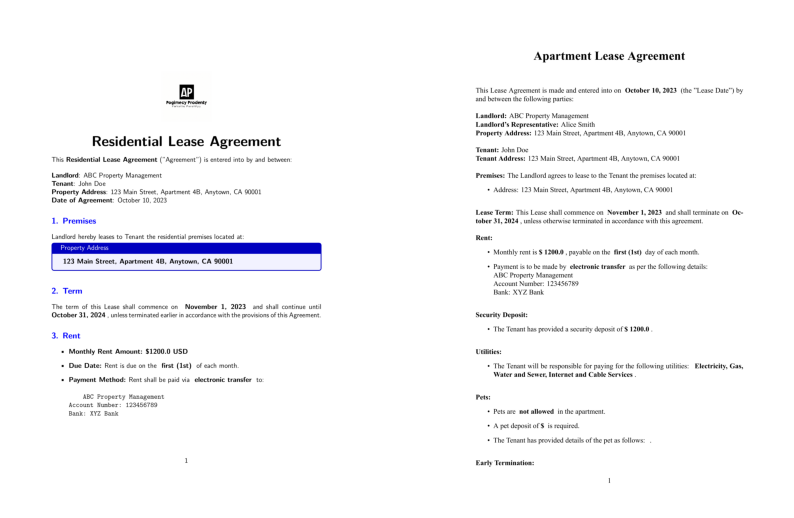

In [4]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

template_1_page = convert_from_path("/content/generated_docs/train/lease_template_abc_property_management.pdf")[0]
template_1_page = template_1_page.convert('RGB')

template_2_page = convert_from_path("/content/generated_docs/train/lease_template2_abc_property_management.pdf")[0]
template_2_page = template_2_page.convert('RGB')

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(template_1_page)
ax1.axis('off')

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(template_2_page)
ax2.axis('off')

plt.show()

## Indexing

With ColPali, you first index the document corpus offline and persist that document index. The index contains the ColPali embeddings, which are rich vector representations of the tokens from the VLM.

In a production scenario, you will likely persist these embeddings in a vector database. It's important to remember, though, is that ColPali represents a document with multiple vectors, to faciliate late-interaction, $MaxSim$ matching between query and document terms.

In this notebook, I just persist the resulting embeddings on disk:

In [5]:
DOC_ROOT = "generated_docs"       # Where documents are unzipped to
DOC_DIRECTORIES = ['train']       # The train subdirectory
INDEX_ROOT = "."                  # Root path for saving the embeddings and document indices
INDEX_FILE = "gen_doc_embeddings" # File name for the doc embeddings
PAGES_FILE = "gen_pages"          # File name for an embedding-to-document-page index (to display matching docs)

In [ ]:
# ColPali recently had a pretty major refactor, so this uses the pre-refactor API.
# TODO: updated to >= 0.3
!pip install -q colpali-engine==0.2.2 typer mteb

In [ ]:
import torch
from transformers import AutoProcessor

from colpali_engine.models.paligemma_colbert_architecture import ColPali
from colpali_engine.trainer.retrieval_evaluator import CustomEvaluator
from colpali_engine.utils.colpali_processing_utils import process_images, process_queries
from colpali_engine.utils.image_from_page_utils import load_from_dataset, load_from_pdf

colpali_model_name = "vidore/colpali-v1.2"
colpali_model = ColPali.from_pretrained("vidore/colpaligemma-3b-pt-448-base", torch_dtype=torch.bfloat16, device_map="cuda").eval()
colpali_model.load_adapter(colpali_model_name)
colpali_model = colpali_model.eval() # we are not training, put in eval mode
colpali_processor = AutoProcessor.from_pretrained(colpali_model_name)

In [17]:
from typing import TypedDict
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import DataLoader

class DocumentPage(TypedDict):
  """ Data structure to keep track of document pages """
  file_path: str
  page_number: int

def index_files(doc_root: str, subdirs: list[str], index_root: str, colpali_processor, colpali_model) -> tuple[Path, Path]:
  files = []
  print("Gathering PDF files...")
  if len(subdirs) > 0:
    for directory in tqdm(subdirs):
      files.extend([str(path) for path in Path(doc_root + "/" + directory).rglob('*.pdf')])
  else:
    files.extend([str(path) for path in Path(doc_root).rglob('*.pdf')])

  print(f"{len(files)} files to index")

  print("Loading images...")
  # a list of PIL.Image lists, where each sublist is pages for that file
  ims: list[list[Image.Image]] = [load_from_pdf(s) for s in tqdm(files)]

  # Keep track of pages for each file
  pages: list[DocumentPage] = []
  for i, a in enumerate(files):
      for z, b_item in enumerate(ims[i]):
          pages.append({'file_path': a, 'page_number': z + 1})

  images = [item for sublist in ims for item in sublist]

  dataloader = DataLoader(
          images,
          batch_size=4,
          shuffle=False,
          collate_fn=lambda x: process_images(colpali_processor, x))

  embeddings = []
  for batch_doc in tqdm(dataloader):
      with torch.no_grad():
        batch_doc = {k: v.to(colpali_model.device) for k, v in batch_doc.items()}
        embeddings_doc = colpali_model(**batch_doc)
        embeddings.extend(list(torch.unbind(embeddings_doc.to("cpu"))))

  print(f"Embeddings: {len(embeddings)}, files: {len(pages)}")
  embeddings_file = Path(index_root) / f"{INDEX_FILE}.pt"
  pages_file = Path(index_root) / f"{PAGES_FILE}.pt"
  torch.save(embeddings, embeddings_file)
  torch.save(pages, pages_file)
  return embeddings_file, pages_file

With this in place, we can now index the document collection. Note that most of the computation is devoted to converting PDF pages to images. Generating the embeddings for each page is relatively fast:

In [18]:
embeddings_file, pages_file = index_files(DOC_ROOT, DOC_DIRECTORIES, INDEX_ROOT, colpali_processor, colpali_model)

Gathering PDF files...


100%|██████████| 1/1 [00:00<00:00, 342.62it/s]


282 files to index
Loading images...


100%|██████████| 157/157 [01:16<00:00,  2.04it/s]


Embeddings: 626, files: 626


## Retrieval

Again, you would likely store these embeddings in a database in a production environments. The ColPali paper mentions that the embeddings are about 250K per page. Because we have just a few documents here, we can load the embeddings and our document page index into memory. (They already are, if you executed the cell above, but you can run the retrieval afterwards too, if you save the embeddings in your Google drive directory so it persists across Colab sessions.)

In [23]:
def load_index(index_root: str) -> tuple[list, list[DocumentPage]]:
  emb = torch.load(Path(index_root) / f"{INDEX_FILE}.pt", weights_only=False)
  pgs: list[DocumentPage] = torch.load(Path(index_root) / f"{PAGES_FILE}.pt", weights_only=False)
  return emb, pgs

embeddings, pages = load_index(INDEX_ROOT)
print(len(embeddings), len(pages))


626 626


We can now pick a random document page to use as the query data:

In [34]:
import copy
import random

def pick_random_doc(embeddings: list[torch.Tensor], pages: list[DocumentPage], page_number: int) -> tuple[list[torch.Tensor], list[torch.Tensor], list[DocumentPage], DocumentPage]:
  embeddings_copy: list[torch.Tensor] = copy.deepcopy(embeddings)
  pages_copy: list[DocumentPage] = copy.deepcopy(pages)

  random.seed(None)
  page_one_indices = [i for i, document_page in enumerate(pages_copy) if document_page['page_number'] == page_number]
  random_ones_index = random.randint(0, len(page_one_indices) - 1)
  random_index = page_one_indices[random_ones_index]
  random_page = pages_copy[random_index]

  # Pop the selected example from the rest of the docs, since we don't want to compare the example document with itself
  example_doc = pages_copy.pop(random_index)
  example_embedding = embeddings_copy.pop(random_index)

  query_docs = [example_embedding]
  return query_docs, embeddings_copy, pages_copy, example_doc

Given the randomly selected document page, and the corpus without the example document, we can now identify pages that are similar to the example image:

In [38]:
import numpy as np

def similar_pages(query_set: list[torch.Tensor], data_set: list[torch.Tensor], pages: list[DocumentPage]):
  retriever_evaluator = CustomEvaluator(is_multi_vector=True)

  # One score for each document in the corpus. Computed using MaxSim
  scores = retriever_evaluator.evaluate(query_set, data_set)

  # A poor person's clustering. Find the top matching document pages.
  # This assumes that there's a larger gap between the cluster of similar documents and the
  # less similar documents. This may not always be true, so this is just for illustration

  arr_flat = scores.flatten()
  sorted_indices = np.argsort(-arr_flat)
  sorted_values = np.array(arr_flat)[sorted_indices]
  sorted_pages = np.array(pages)[sorted_indices]
  sorted_positions = np.unravel_index(sorted_indices, arr_flat.shape)

  differences = np.diff(sorted_values)

  # Find the largest gap in the scores
  largest_diff_index = np.argmin(differences)
  closest_pages = sorted_pages[:largest_diff_index + 1]
  return closest_pages

Finally, let's display the randomly selected example and the top 3 closest-matching pages:

In [50]:
import os

def show_images(example: DocumentPage, similar_images: list[DocumentPage]):
  K = len(similar_images)
  MAX_IMAGES = 3
  if K >= MAX_IMAGES:
      K = MAX_IMAGES

  example_doc_pages = load_from_pdf(example['file_path'])
  example_im = example_doc_pages[example['page_number'] - 1]

  fig = plt.figure(figsize=(18, 24))
  gs = GridSpec(2, K, figure=fig, height_ratios=[2, 1])

  # The selected example image
  ax1 = fig.add_subplot(gs[0, :KeyError])
  ax1.set_title(os.path.basename(example['file_path']), fontsize=18)
  ax1.imshow(example_im)
  ax1.axis('off')

  # Top K matching images
  ROW = 1
  for i, img in enumerate(similar_images[:K]):
      doc_pages = load_from_pdf(img['file_path'])
      print(img)
      im = doc_pages[int(img['page_number']) - 1]
      im = np.array(im)
      ax = fig.add_subplot(gs[ROW, i - 1])
      ax.set_title(f"{os.path.basename(img['file_path'])}, page {img['page_number']}", fontsize=14)
      ax.imshow(im)
      ax.axis('off')

  plt.tight_layout()
  plt.show()

With this in place, we can select a random doc page, and display the 3 top matches from the rest of the corpus. You can keep executing the below cell to repeat the process with a new example page:

tensor([82])
Top 1 Accuracy (verif): 0.0
Example file is generated_docs/train/personal_trainer_template2_liam_martinez.pdf, page 1. Found 39 similar pages
{'file_path': 'generated_docs/train/personal_trainer_template2_daniel_miller.pdf', 'page_number': 1}
{'file_path': 'generated_docs/train/personal_trainer_template2_alex_johnson.pdf', 'page_number': 1}
{'file_path': 'generated_docs/train/personal_trainer_template2_chris_johnson.pdf', 'page_number': 1}


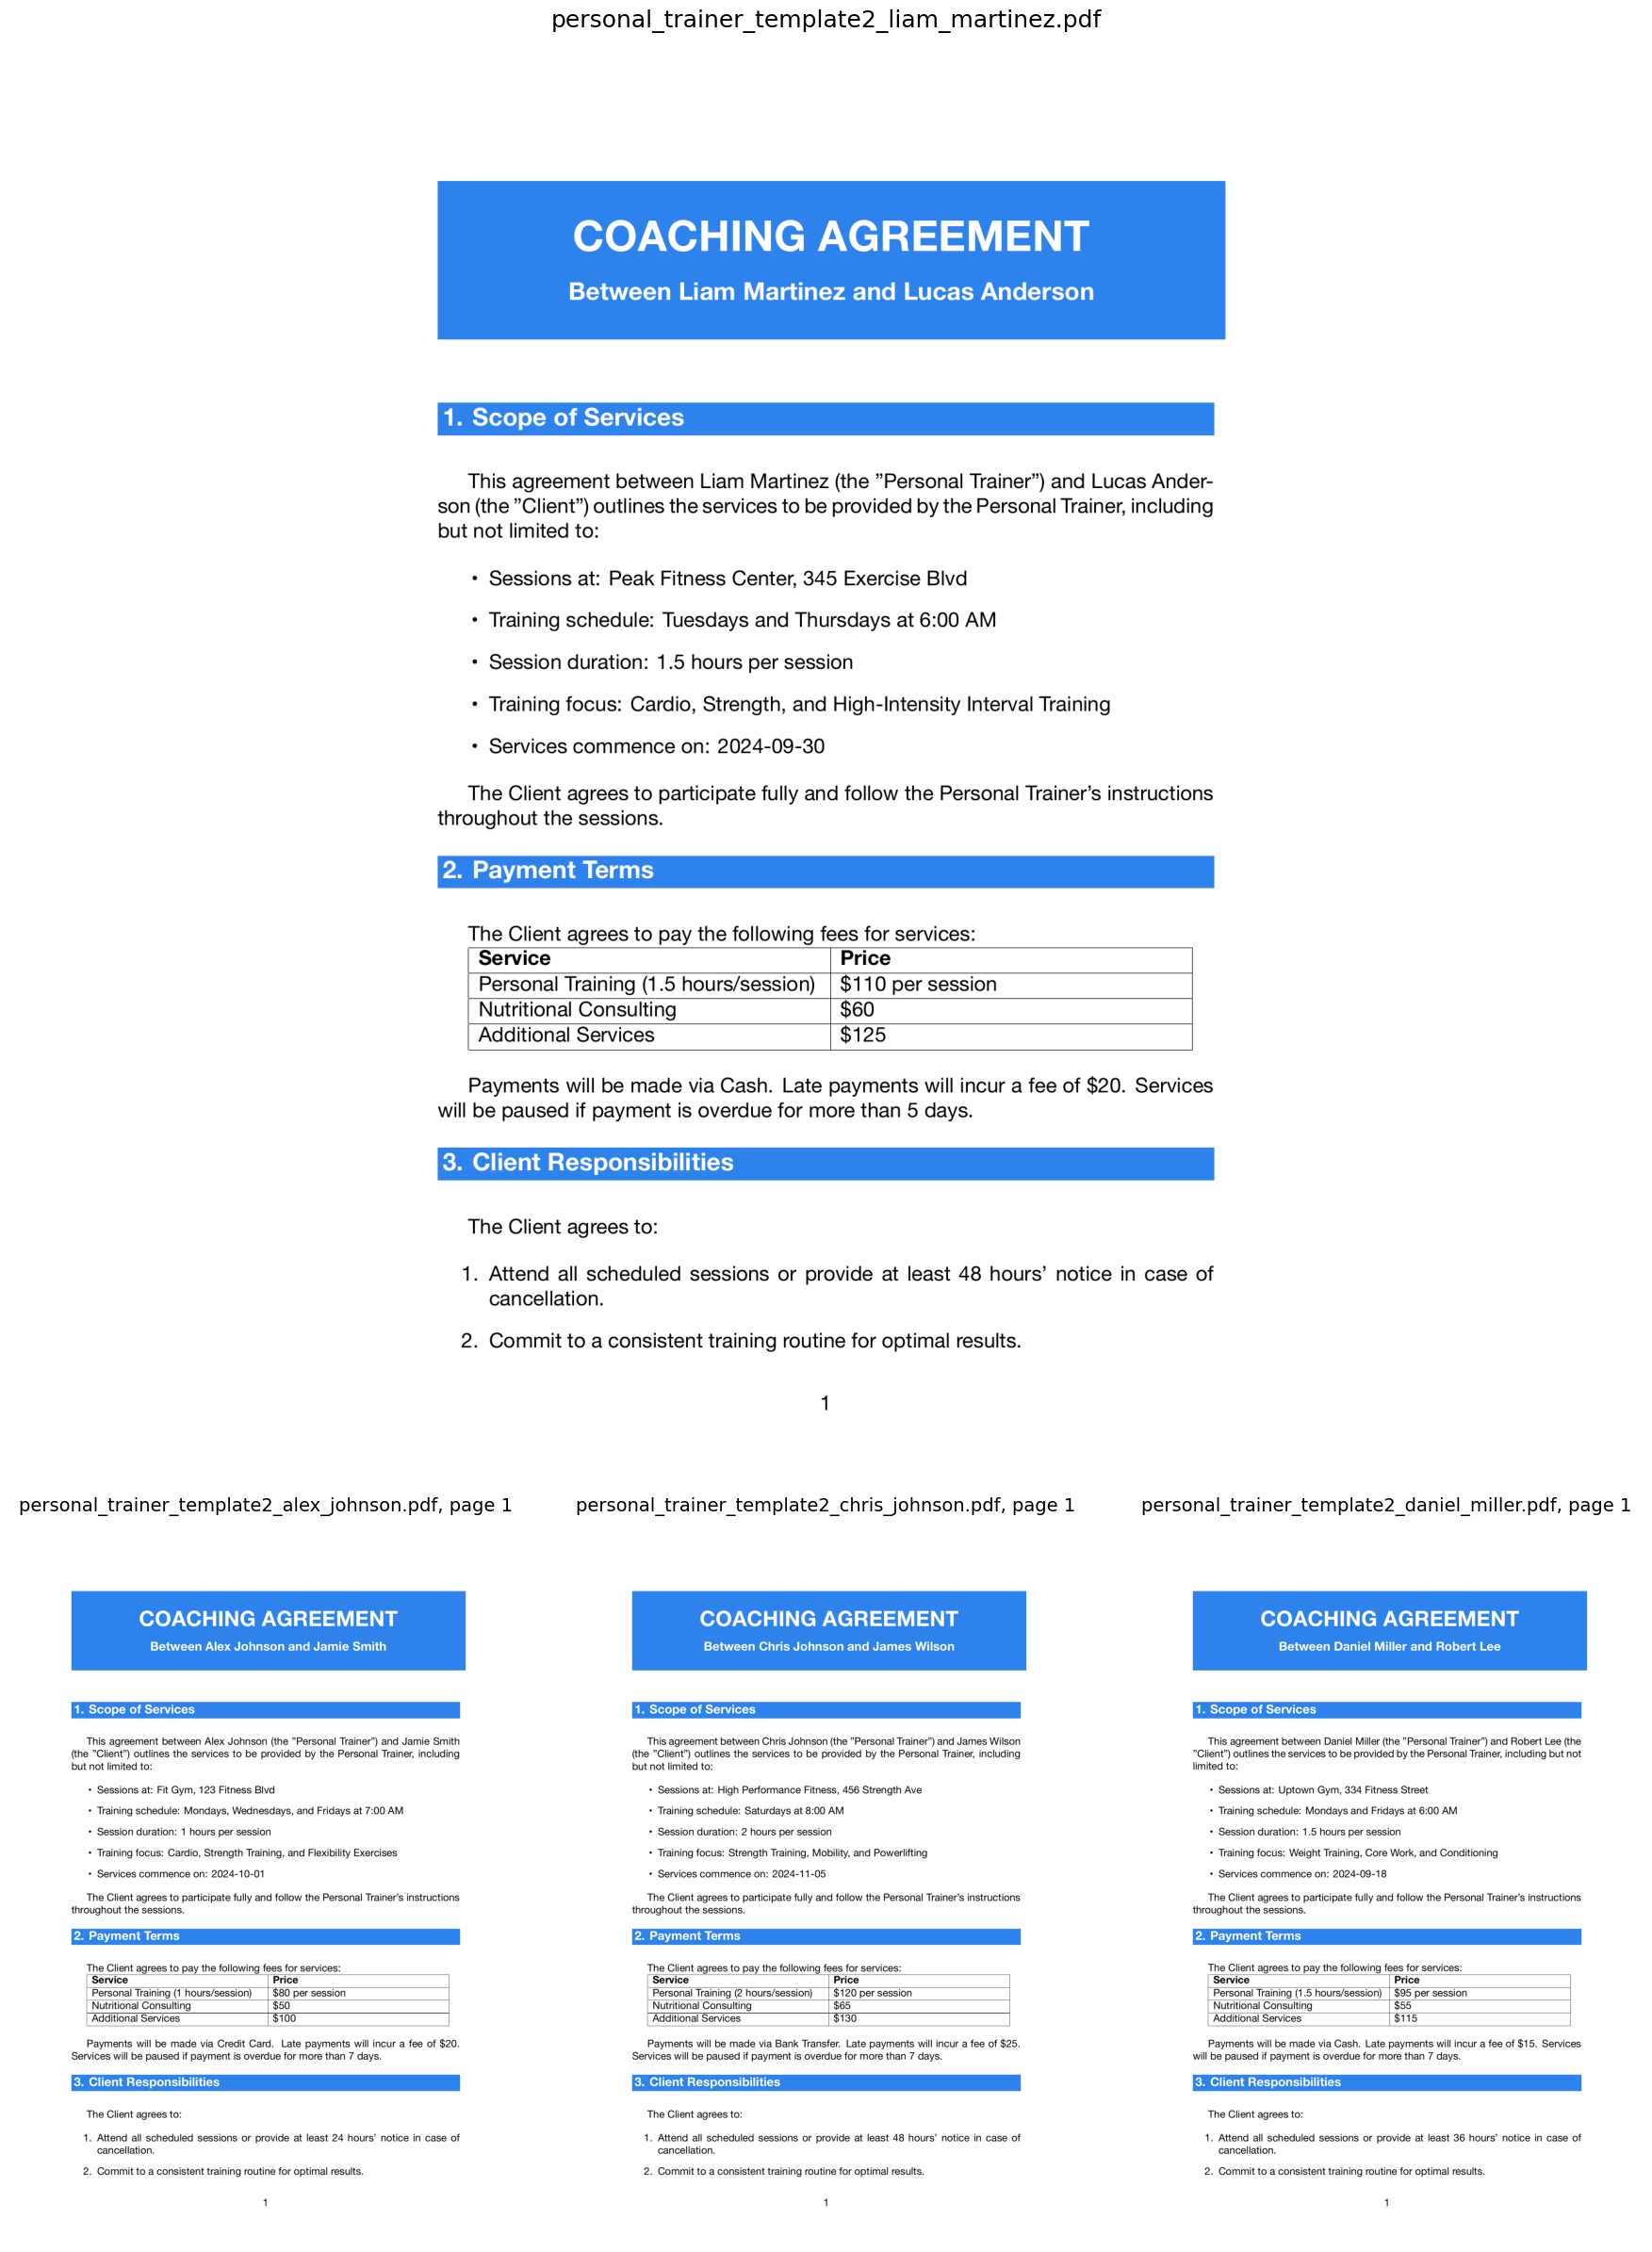

In [49]:
query, dataset, pg, ex_doc = pick_random_doc(embeddings, pages, page_number=1)
similar = similar_pages(query, dataset, pg)
print(f"Example file is {ex_doc['file_path']}, page {ex_doc['page_number']}. Found {len(similar)} similar pages")

show_images(ex_doc, similar)